In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("../paper.mplstyle")

from os import sys
sys.path.append('/data/user/jlazar/solar_WIMP/')

import dicts
from scipy.special import gamma
from scipy.optimize import broyden1
from scipy.interpolate import UnivariateSpline

sd_limits = dicts.sd_limit_dict
sd_anns   = dicts.sd_ann_rate_dict # annihilation rate for xs=1pb

In [2]:
data_path = "/data/user/jlazar/solar_WIMP/data/"

min_exp   = 0.5
max_exp   = 6.5

chs = [5, 8, 11]
ms  = [300,500,1000,3000,5000,10000]

mu_pion         = np.load("%s/e_d_theta_hist/pion_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_pion_bar     = np.load("%s/e_d_theta_hist/pion_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon         = np.load("%s/e_d_theta_hist/kaon_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon_bar     = np.load("%s/e_d_theta_hist/kaon_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_bg_tot       = mu_pion + mu_pion_bar + mu_kaon + mu_kaon_bar

In [3]:
bb_lims = np.genfromtxt("../data/3y_sd_bb_limits.csv", delimiter=",").T
ww_lims = np.genfromtxt("../data/3y_sd_ww_limits.csv", delimiter=",").T
tt_lims = np.genfromtxt("../data/3y_sd_tt_limits.csv", delimiter=",").T

bb_sens = np.genfromtxt("../data/3yr_bb_sens.csv", delimiter=",").T
ww_sens = np.genfromtxt("../data/3yr_ww_sens.csv", delimiter=",").T
tt_sens = np.genfromtxt("../data/3yr_tt_sens.csv", delimiter=",").T

lims = [bb_lims, ww_lims, tt_lims]
lim_funcs = {}
for i, ch in enumerate(chs):
    lim_funcs[ch] = UnivariateSpline(np.log10(lims[i][0]), np.log10(lims[i][1]), k=3, s=1e-2)
    
senss = [bb_sens, ww_sens, tt_sens]
sens_funcs = {}
for i, ch in enumerate(chs):
    sens_funcs[ch] = UnivariateSpline(np.log10(senss[i][0]), np.log10(senss[i][1]), k=3, s=1e-2)
    
def get_limit(x, ch):
    log10x = np.log10(x)
    return np.power(10, lim_funcs[ch](log10x))
def get_sens(x, ch):
    log10x = np.log10(x)
    return np.power(10, sens_funcs[ch](log10x))

In [4]:
red_bound  = np.genfromtxt("..sd_xc_floor_red.csv", delimiter=",").T
blue_bound = np.genfromtxt("sd_xc_floor_blue.csv", delimiter=",").T

rs = UnivariateSpline(np.log10(red_bound[0]), np.log10(red_bound[1]),s=1e-3)
bs = UnivariateSpline(np.log10(blue_bound[0]), np.log10(blue_bound[1]),s=1e-2)
def get_bound(m, bound):
    lm = np.log10(m)
    if bound=="red":
        s = rs
    elif bound=="blue":
        s = bs
    else:
        print("wrong bound buddy")
    return np.power(10, s(lm))

plt.plot(red_bound[0], red_bound[1], "r")
plt.plot(np.logspace(1.5,3.5, 100),get_bound(np.logspace(1.5,3.5, 100),"red"))
plt.plot(blue_bound[0], blue_bound[1], "b")
plt.plot(np.logspace(1.5,3.5, 100),get_bound(np.logspace(1.5,3.5, 100),"blue"))


plt.loglog()
plt.show()

IOError: ..sd_xc_floor_red.csv not found.

In [5]:
def round_sig_figs(x, sig_figs=2):
    return round(x, sig_figs-int(np.floor(np.log10(abs(x))))-1)

In [6]:
def factorial(x):
    x = np.asarray(x)
    return gamma(x+1)

In [7]:
class poisson():
    
    def __init__(self, mu):
        self.mu      = mu
        self.var     = mu
        self.std     = np.sqrt(mu)
        self.mean    = mu
        self.int_val = quad(self.val, 0, 10*self.std+mu)[0]
    
    def val(self, x):
        return np.exp(-self.mu) * np.power(self.mu, x) / factorial(x)
        
    def pdf(self, x):
        return self.val(x) / self.int_val
    
    def cdf(self, x):
        q = quad(self.pdf, 0, x)
        print(q[1])
        return q[0]

In [8]:
def neg_log_likelihood(mu_s, n_s, mu_b, n_b):
    """
    mu_s float: mean number of signal events
    n_s  int  : observed number of signal events
    mu_b float: mean number of background events
    n_b  int  : observed number of bacground events
    """
    mu_s = np.asarray(mu_s)
    mu_b = np.asarray(mu_b)
    n_b  = np.asarray(n_b)
    n_s  = np.asarray(n_s)
    mu = mu_s*n_s + mu_b*n_b
    lh = -np.log(np.exp(-mu) * np.power(mu, mu_b) / factorial(mu_b))
    lh = lh[np.where(~np.isnan(lh))]
    lh = lh[np.where(~np.isinf(lh))]
    return np.sum(lh)

In [9]:
def calc_sens(mu_b, mu_s, fudge=1):
    
        
    n_b  = 1
    
    yint = 2.71
    
    try:
        neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_b, n_b)
        func = lambda x: neg_log_likelihood(mu_s, x, mu_b, n_b)-neg_log_likelihood_0 - yint
        sens = broyden1(func, 0.5) * 1e-39 # cm^{2}
    except:
        neg_log_likelihood_0 = neg_log_likelihood(mu_s*1e3, 0, mu_b, n_b)
        func = lambda x: neg_log_likelihood(mu_s*1e3, x, mu_b, n_b)-neg_log_likelihood_0 - yint
        sens = broyden1(func, 0.5) * 1e-36 # cm^{2}
    return sens

In [6]:
delta_t = 30*60
ch = 11
m = 1000
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
mu_s = factor*np.load("../data/e_d_theta_hist/ch11-m1000_Ares-IC86.AVG-1.27-lite-platinum-25000_e_d_theta.npy")
mu_b = np.load("../data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
calc_sens(mu_b, mu_s)

IOError: [Errno 2] No such file or directory: '../data/e_d_theta_hist/ch11-m1000_Ares-IC86.AVG-1.27-lite-platinum-25000_e_d_theta.npy'

In [18]:
sens_dict          = {ch:{} for ch in chs}
rescaled_sens_dict = {ch:{} for ch in chs}

delta_t = 30 * 60

for m in [500, 1000, 5000, 10000]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    for ch in chs:
        mu_b = np.load("../data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
        mu_s = factor * np.load("%s/e_d_theta_hist/ch%d_m%d_f1.000000_f_tot_e_d_theta_hist.npy" % (data_path, ch, m))
        sens = calc_sens(mu_b, mu_s)
        sens_dict[ch][m] = sens
for m in [300, 500, 1000, 3000, 5000, 10000]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    for ch in chs:
        mu_s = 1.e-4 * factor * np.load("%s/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_rescale.npy" % (data_path, ch, m)).T
        sens = calc_sens(mu_bg_tot, mu_s)
        rescaled_sens_dict[ch][m] = sens

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


NameError: name 'sens_dict' is not defined

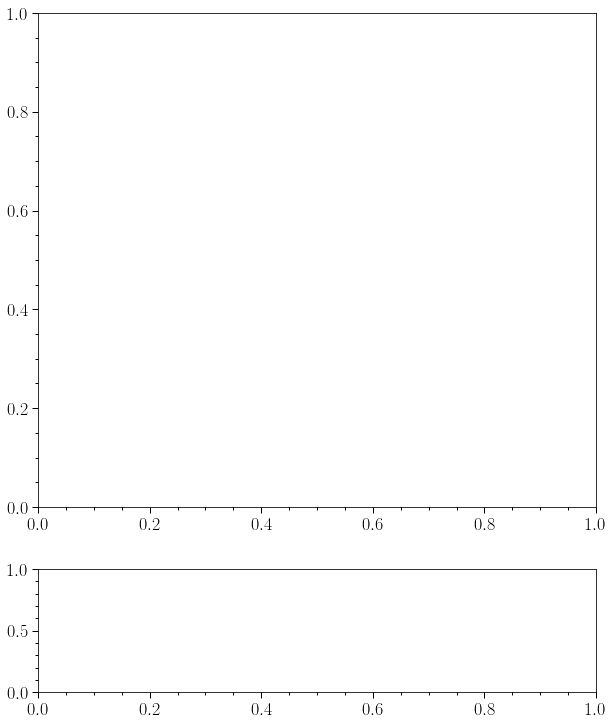

In [41]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1] * scale, "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(get_limit(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"3 year limits $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("../plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()

# Use sensitivities instead of limits

((300, 500, 1000, 3000, 5000, 10000), array([ 0.0223619 ,  1.68967089,  6.51597538, 10.94223994, 11.47673641,
       11.39687791]))


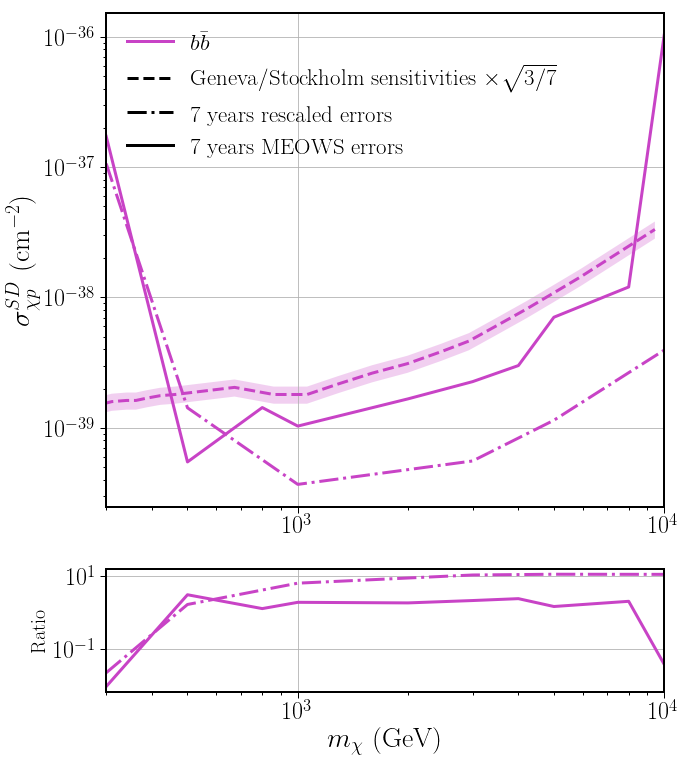

((300, 500, 1000, 3000, 5000, 10000), array([1.38666065, 1.91460505, 1.74574092, 1.66656884, 1.62040745,
       1.81110681]))


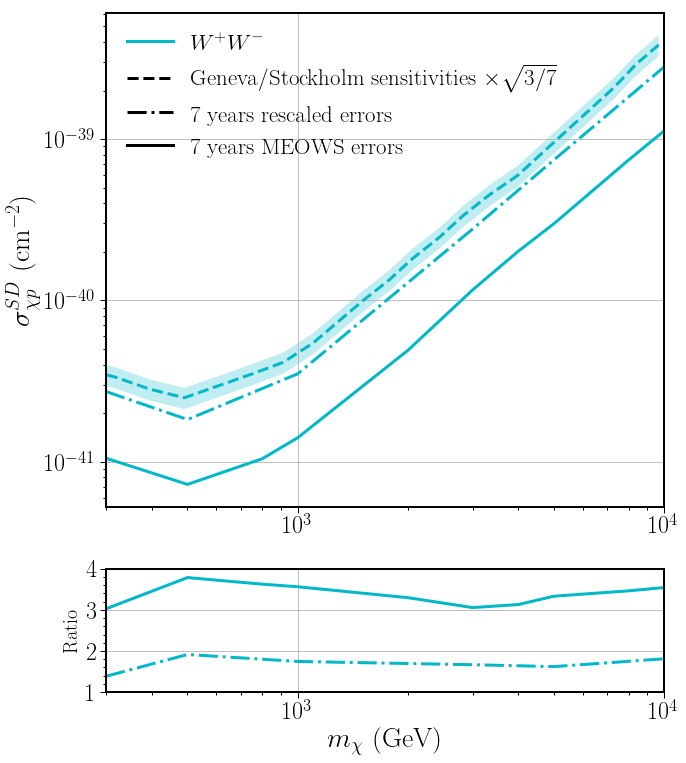

((300, 500, 1000, 3000, 5000, 10000), array([0.8345124 , 1.47763617, 1.63084799, 1.51804079, 1.51238287,
       1.79556907]))


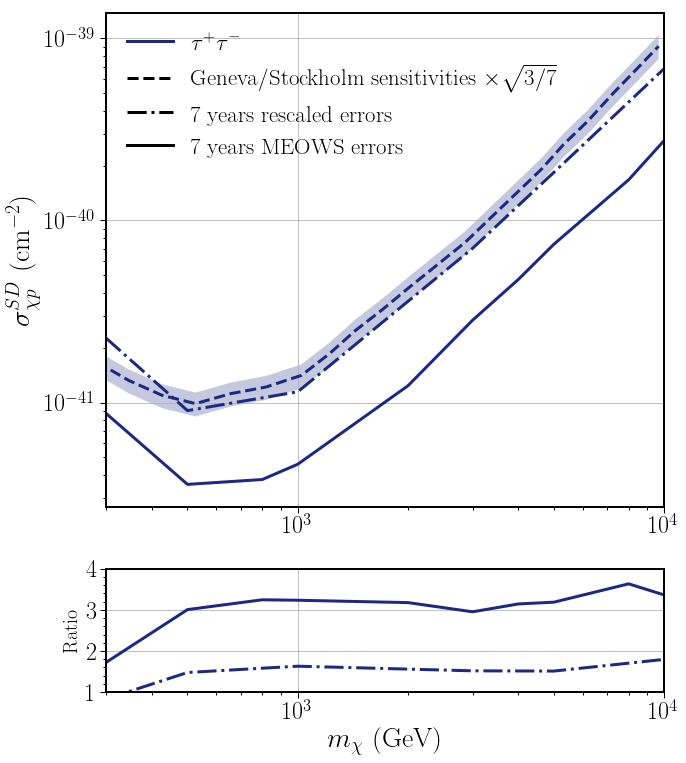

In [47]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1] * scale, "--", color=cs[i], lw=lw)

    
    
    ax2.plot(ms, np.divide(get_sens(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    print(ms, np.divide(old_sens[i] * scale, sens))
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    else:
        ax2.semilogx()
        ax2.set_ylim(1, 4)
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"Geneva/Stockholm sensitivities $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()

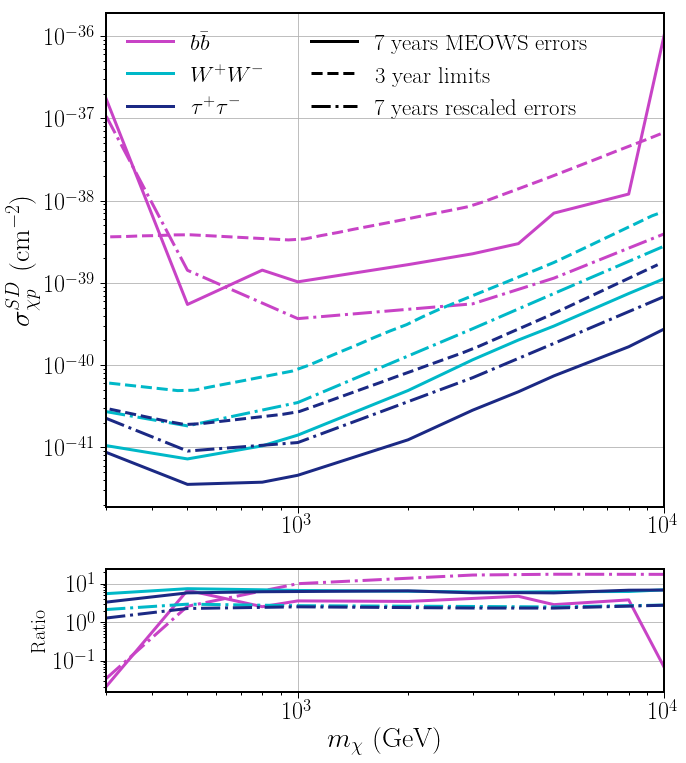

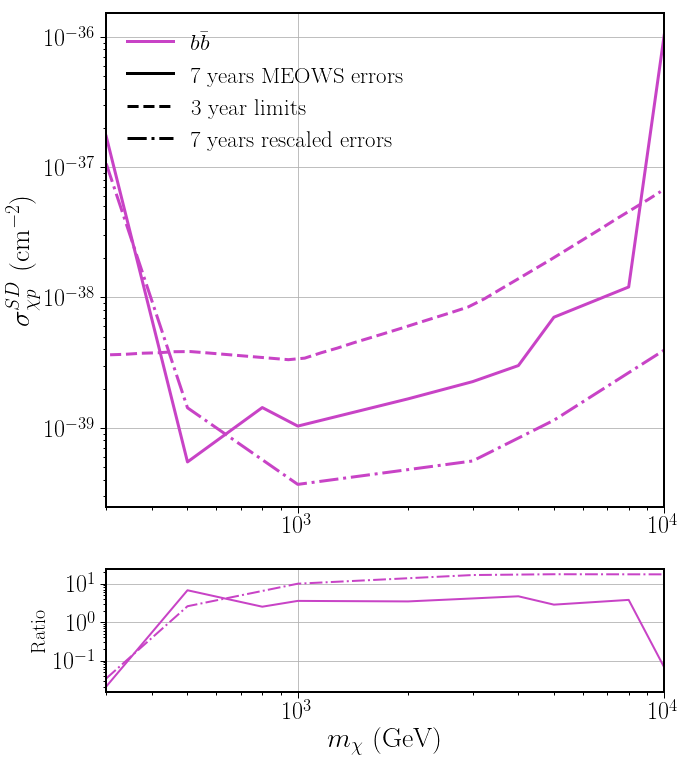

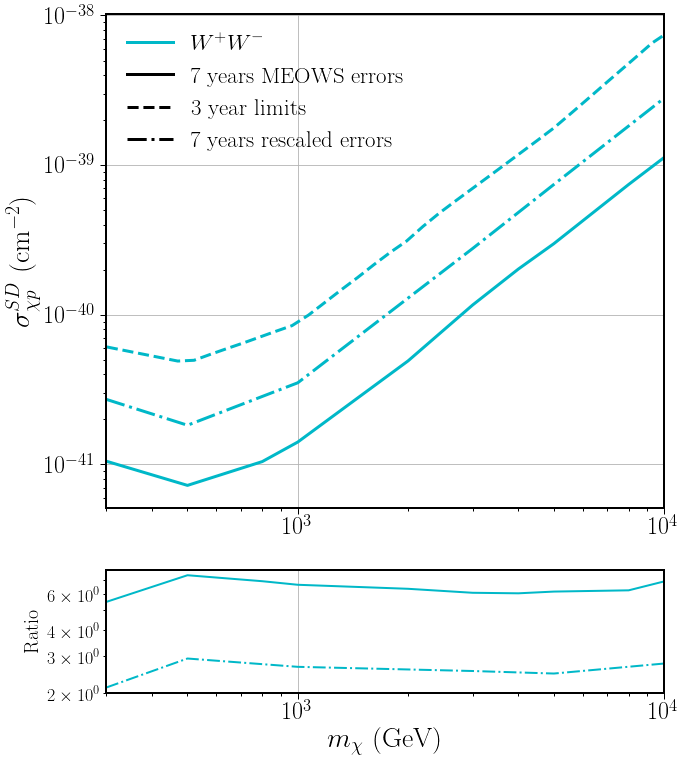

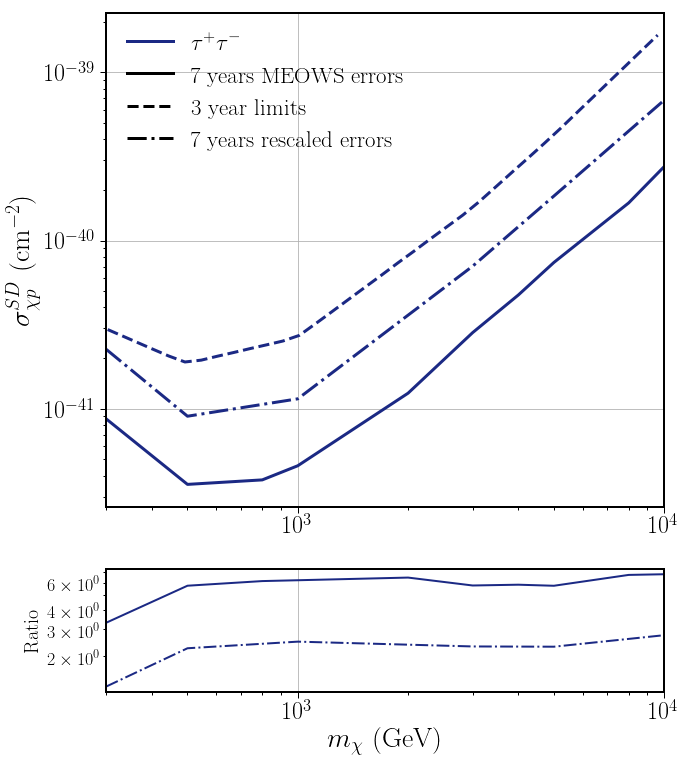

In [48]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))


for i, ch in enumerate(chs):
    
   
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.", lw=lw)
    

ax1.set_xlim(300, 10000)
ax2.set_xlim(300, 10000)
ax1.loglog()
ax2.loglog()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("plots/stat_only_sensitivity_combined_w_ratio.png")

plt.show()

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.")
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_combined_w_ratio.png" % ch)
    
    plt.show()

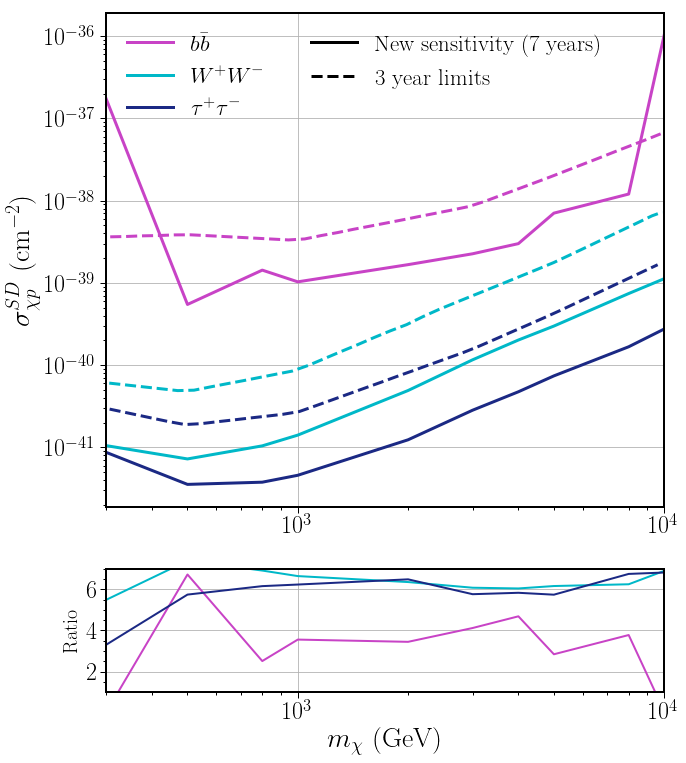

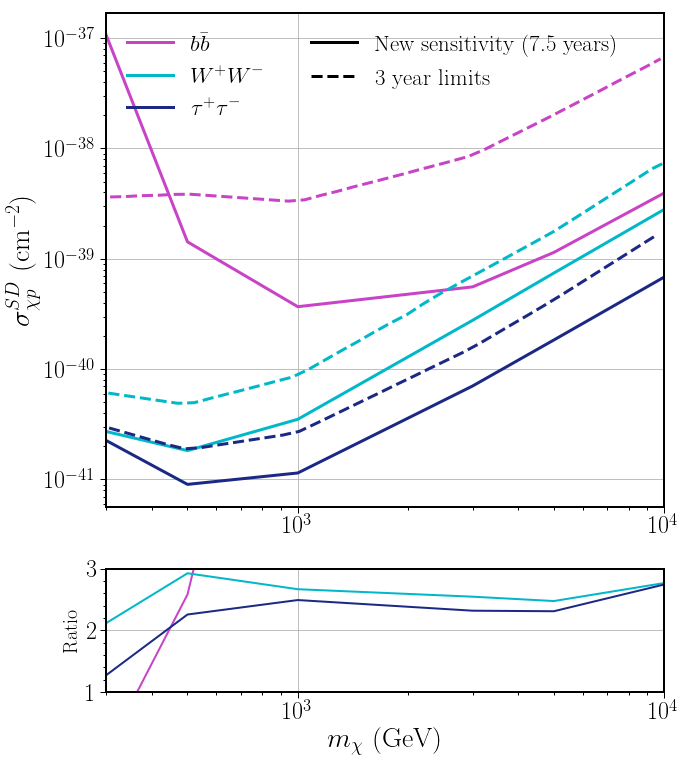

In [49]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
   
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax2.set_ylim(1,7)

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


legend_elements = []

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax2.set_ylim(1,3)
ax1.loglog()
# ax2.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7.5 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_3y_error_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()

((300, 500, 1000, 3000, 5000, 10000), array([ 0.06127532,  4.77200465, 20.9196364 , 33.17414887, 34.37057751,
       37.10884691]))
((300, 500, 1000, 3000, 5000, 10000), array([4.57535801, 5.691683  , 5.34483569, 4.76024215, 4.98900014,
       5.30033136]))
((300, 500, 1000, 3000, 5000, 10000), array([2.6066389 , 4.5315004 , 4.85708685, 4.42087112, 4.77601105,
       5.02879045]))


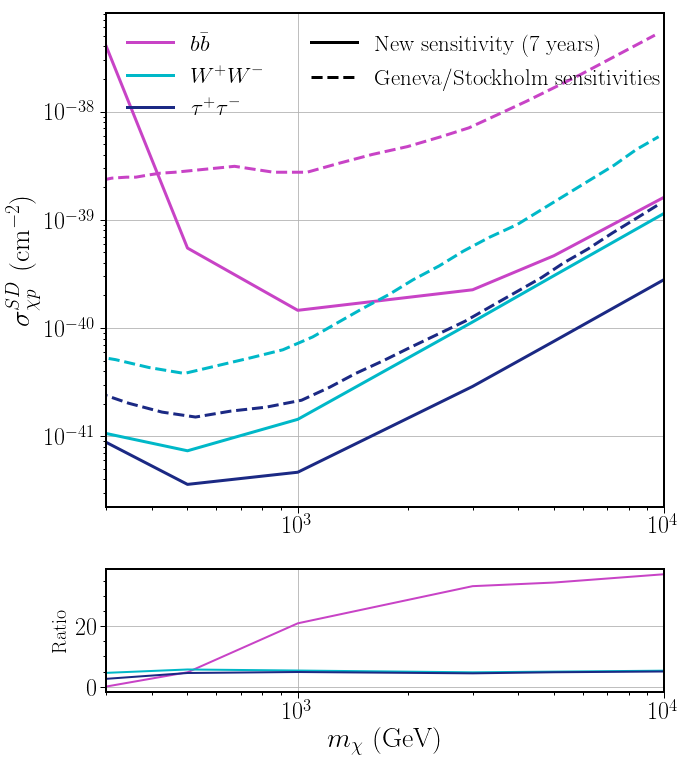

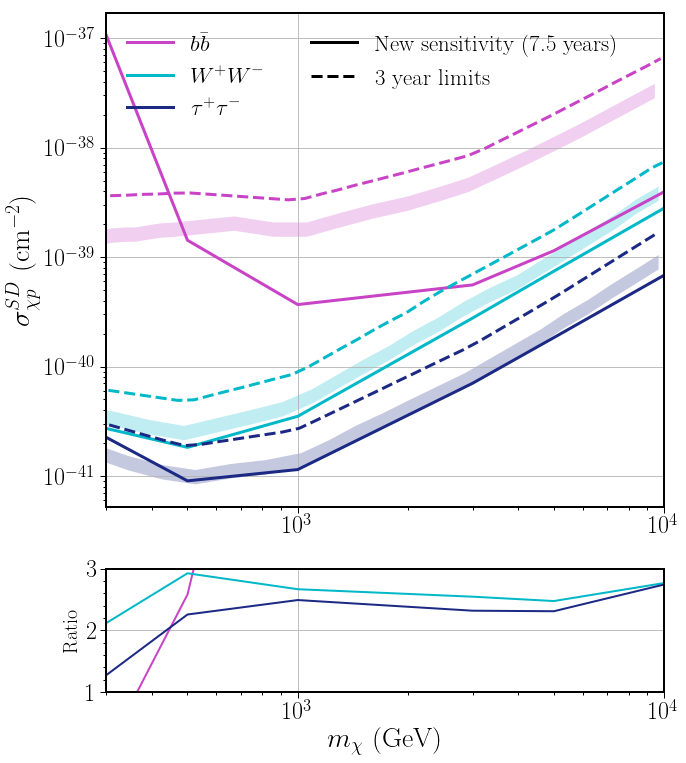

In [159]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]



lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_sens(ms, ch), sens), color=cs[i])
    print(ms, np.divide(get_sens(ms, ch),sens))
   
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="Geneva/Stockholm sensitivities", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


legend_elements = []

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax2.set_ylim(1,3)
ax1.loglog()
# ax2.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7.5 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_3y_error_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


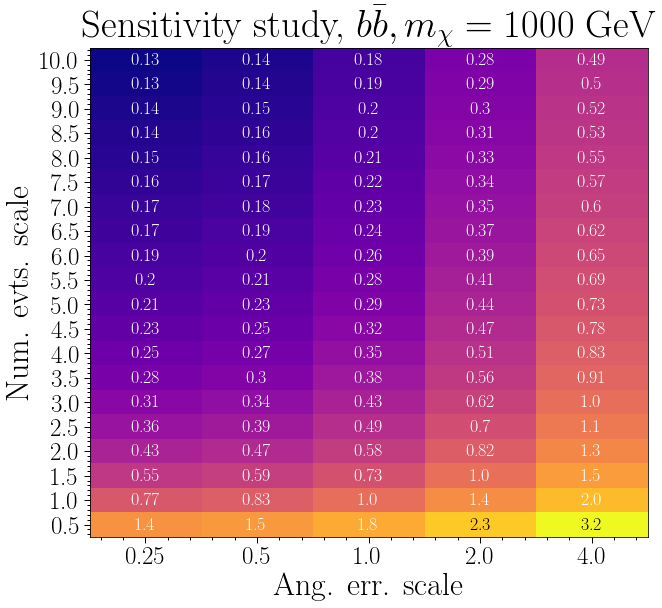

In [71]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 5

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/sens_dict[ch][m])[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        if i==19 and j in [3,4]:
            text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j])),
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j])),
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


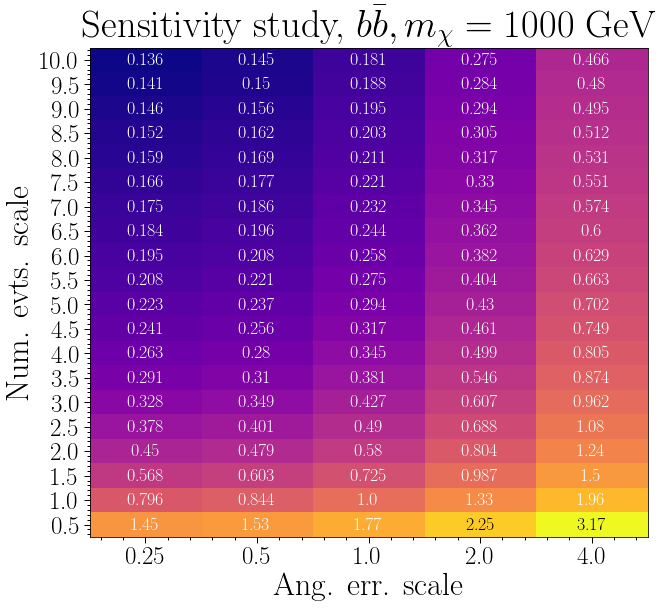

In [75]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 8

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/sens_dict[ch][m])[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        t = round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3)
        if i==19 and j in [3,4]:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

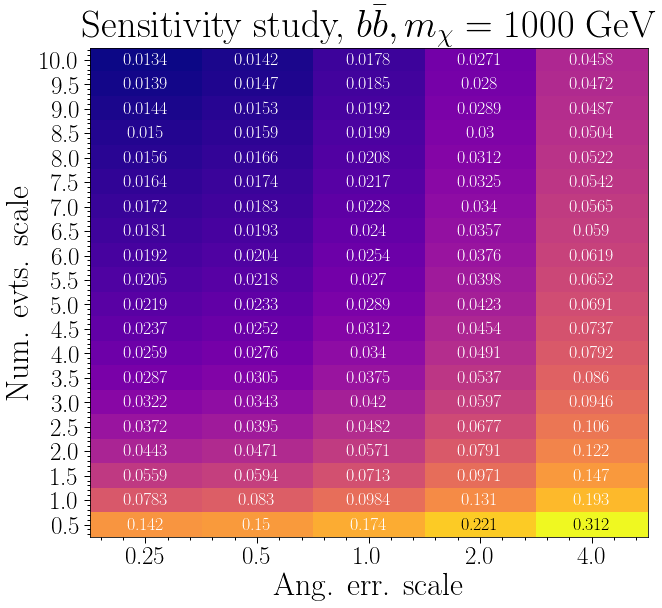

In [76]:
# X,Y=np.meshgrid(ang_err_scals, num_evt_scals)

l_rat = np.log10(sens_arr/1.4585694051687332e-40)[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        t = round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3)
        if i==19 and j in [3,4]:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


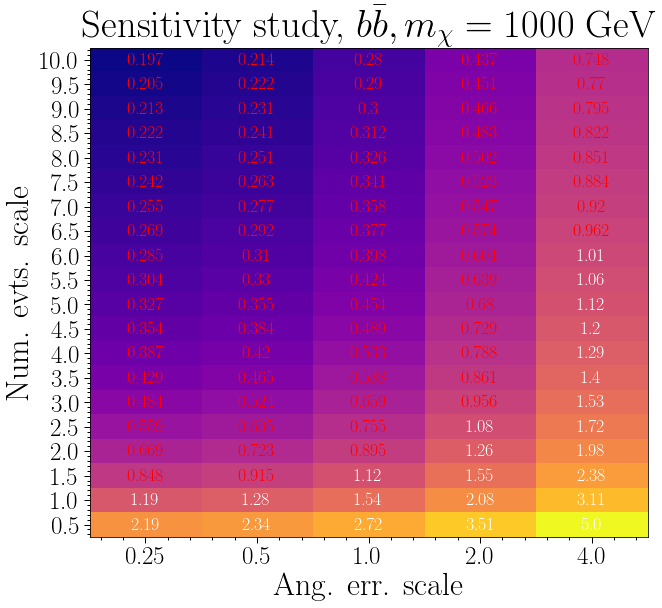

In [73]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 5

rb = get_bound(m, "red")
bb = get_bound(m, "blue")


text_cs = np.full(((len(num_evt_scals), len(ang_err_scals))), "white")

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        if sens/rb>1:
            text_cs[j,k]="white"
#             print("white", sens, rb)
        elif sens/bb<1:
            text_cs[j,k]="blue"
#             print("blue", sens, bb)
        else:
            text_cs[j,k]="red"
#             print("red", sens, rb)
            
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/rb)[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3),
                       ha="center", va="center", color=text_cs[::-1,::-1][i,j], fontsize=18)
        

plt.show()

In [36]:
for m in [1000, 500,3000,5000,10000,300]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch5_m10000_f1.000000_nu_0_energy_delta_theta_hist_im_gonna_scream.npy").shape)
    for i in range(100):
        h+=np.load("data/e_d_theta_hist/partial_hists/ch5_m%d_f1.000000_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (m,i))
        h+=np.load("data/e_d_theta_hist/partial_hists/ch5_m%d_f1.000000_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (m,i))
    mu_s = factor*h.T[::-1].T
    sens = calc_sens(mu_bg_tot, mu_s)
    sens_dict[5][m] = sens
    print(sens)


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


1.0478827134438623e-39
5.522938986643158e-40
2.2968262896621926e-39
7.172981334981606e-39
1.8182845771194386e-38
1.7466708589850702e-37


((300, 500, 1000, 3000, 5000, 10000), array([ 0.0223619 ,  1.68967089,  6.51597538, 10.94223994, 11.47673641,
       11.39687791]))


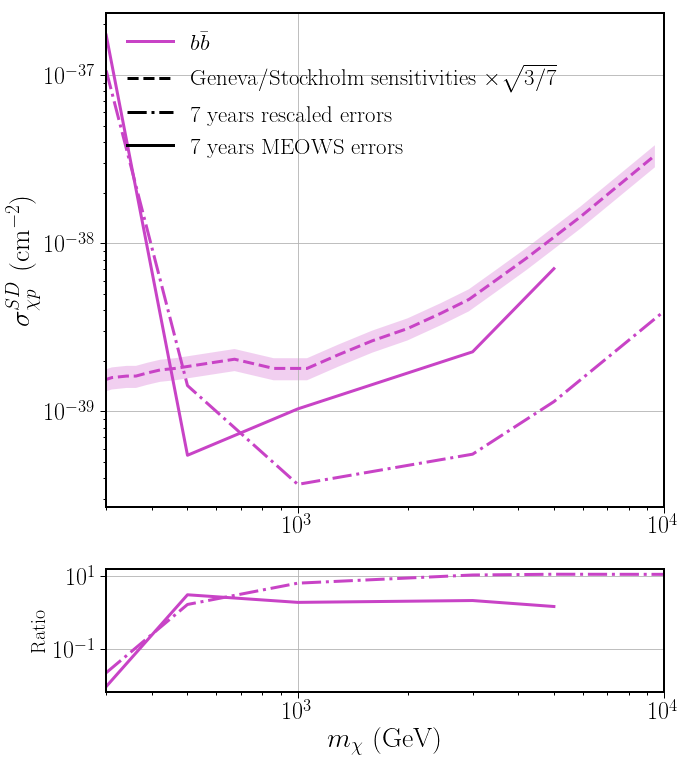

((300, 500, 1000, 3000, 5000, 10000), array([1.38666065, 1.91460505, 1.74574092, 1.66656884, 1.62040745,
       1.81110681]))


In [ ]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(new_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1] * scale, "--", color=cs[i], lw=lw)

    
    
    ax2.plot(ms, np.divide(get_sens(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    print(ms, np.divide(old_sens[i] * scale, sens))
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    else:
        ax2.semilogx()
        ax2.set_ylim(1, 4)
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"Geneva/Stockholm sensitivities $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


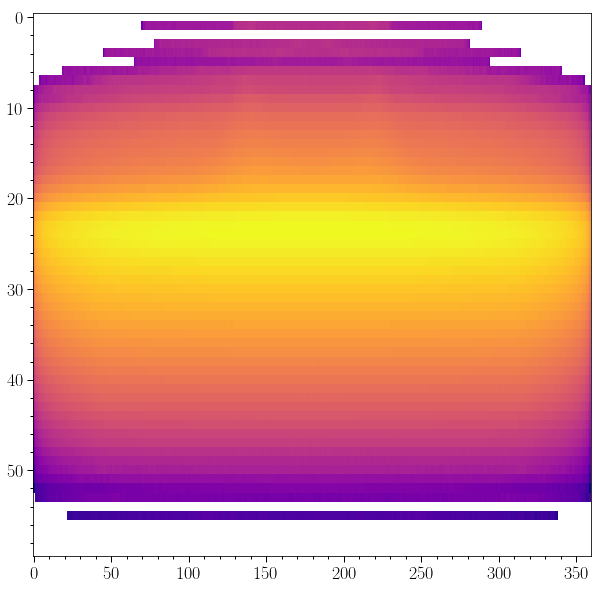

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


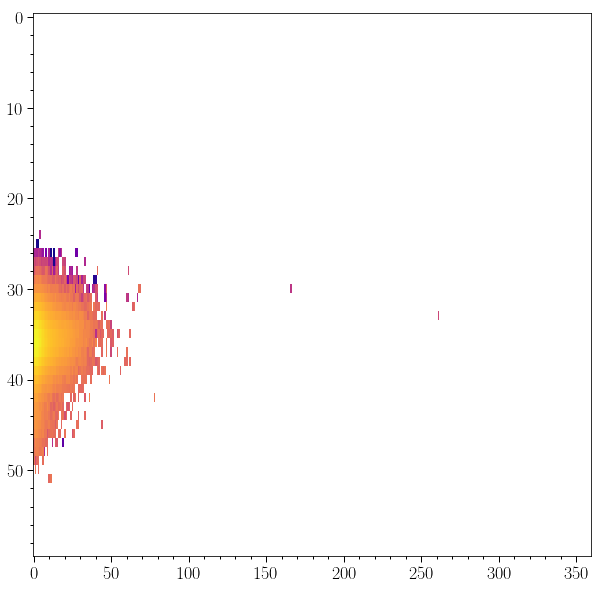

In [16]:
_ = np.load("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
plt.imshow(np.log10(_), aspect="auto")
plt.show()
_ = np.load("data/e_d_theta_hist/ch5_m2000_f1.000000_f_tot_e_d_theta_hist.npy")
plt.imshow(np.log10(_), aspect="auto")
plt.show()

In [173]:
m = 1000
delta_t = 30 * 60
factor = sd_anns[m] * delta_t * 1e-3 * 1./m
mu_b = np.load("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
mu_s = factor*np.load("data/e_d_theta_hist/ch8_m%d_tot_e_d_theta_hist.npy" % m).T
calc_sens(mu_bg_tot,mu_s)

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


1.445168979157033e-41

In [170]:
ch      = 8
m       = 1000
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

mu_s    = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy"  % (ch,m)).T
print(np.sum(mu_s))
print(np.sum(mu_bg_tot))

print(calc_sens(mu_bg_tot, mu_s))

mu_b = np.load("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
mu_s = factor * np.load("data/e_d_theta_hist/ch%d_m%d_f1.000000_f_tot_e_d_theta_hist.npy" % (ch,m))
print(np.sum(mu_s))
print(np.sum(mu_b))
print(calc_sens(mu_b,mu_s))

165.46517847962338
132435.66095861286
1.4351797655604645e-41
165.21610598051592
132435.66095861286
1.4108371971374169e-41


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


In [19]:
import tables
f = "/data/ana/SterileNeutrino/IC86/HighEnergy/MC/Systematics/HoleIce1/Ares/IC86.AVG/Merged/Ares_IC86.AVG_1.27_lite_platinum_99510.h5"
h5f = tables.File(f,"r")

In [40]:
# factors = {8: {1000: 0.9593842811606094, 5000: 1.0770221620269986, 500: 0.9778717548977055, 10000: 1.1811719179962128}, 11: {1000: 0.9890542223339752, 5000: 0.9861406456280182, 500: 0.9899909006380022, 10000: 0.9900561539905951}, 5: {1000: 4.1444992398149685, 5000: 11.7349456037548, 500: 2.9056570612512664, 10000: 8.828344579070064}}
factors = {8: {800: 1.0547596685642981, 8000: 1.5027805067527138, 5000: 1.3935697935234983, 300: 0.4572832063330294, 10000: 1.534245145450004, 1000: 1.135581605961949, 500: 0.8117487951333787, 3000: 1.3301817999848538},
           11: {800: 0.931645431976636, 8000: 1.315035584464548, 5000: 1.2865950052279687, 300: 0.3246542031485803, 10000: 1.3032921364645331, 1000: 1.0482530643420536, 500: 0.6449432675037643, 3000: 1.2886697171825534},
           5: {800: 1.434936995361807, 8000: 6.128715732913227, 5000: 8.216690636601792, 300: 0.05783463447411727, 10000: 5.765144365131035, 1000: 1.538778941437096, 500: 0.49632052982865693, 3000: 4.44048071336551}
          }

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


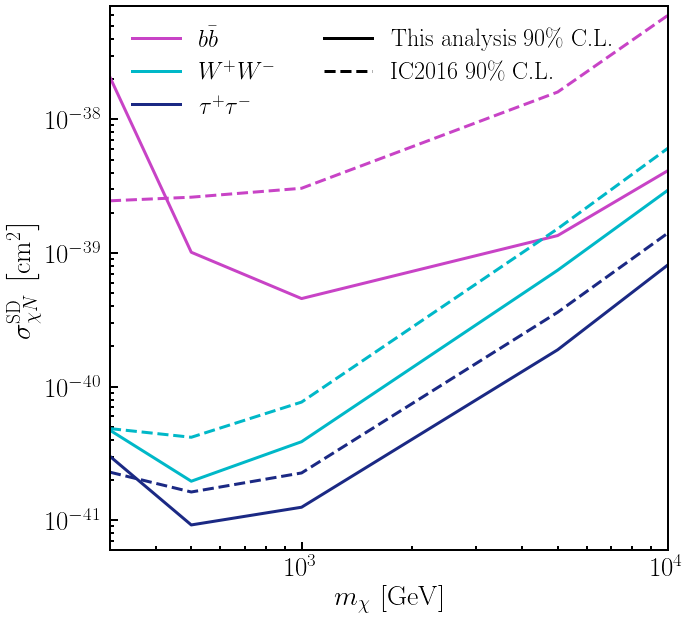

In [12]:
plt.style.use("../paper.mplstyle")

chs = [5,8,11]
ms  = [300, 500, 1000, 5000, 10000]
cs  = ["#C843C6", "#00B8C8", "#1B2984"]
lw  = 3
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
delta_t = 30*60

ylims = (6e-42, 7e-38)
xlims=(300,10000)
# old_lims_scaled = [[sd_limits[ch][m]*1e-36/factors[ch][m] for m in ms] for ch in chs]
# old_lims = [[sd_limits[ch][m]*1e-36 for m in ms] for ch in chs]
old_sens = [[np.power(10, sens_funcs[ch](np.log10(m))) for m in ms] for ch in chs]

fig = plt.figure(figsize=(10,10))

legend_elements = [Line2D([0], [0], color=cs[0], linestyle="-", label=r"$b\bar{b}$", lw=lw),
                   Line2D([0], [0], color=cs[1], linestyle="-", label=r"$W^{+}W^{-}$", lw=lw),
                   Line2D([0], [0], color=cs[2], linestyle="-", label=r"$\tau^{+}\tau^{-}$", lw=lw),
                   Line2D([0], [0], color="black", linestyle="-", label=r"This analysis 90\% C.L.", lw=lw),
                   Line2D([0], [0], color="black", linestyle="--", label=r"IC2016 90\% C.L.", lw=lw),
                  ]


for i, (c, ch, chstr) in enumerate(zip(cs,chs, ch_strs)):
    lims = []
    rs_lims = []
    for m in ms:

        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

        if m in [500,1000,5000,10000]:
            signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
        else:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
            
        bg  = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t
        
        lims.append(calc_sens(bg, signal))
#     ax0.plot(ms, np.asarray(lims), color=c, lw=lw, label=chstr)
    plt.plot(ms, np.asarray(lims), color=c, lw=lw)
    plt.plot(ms, old_sens[i], color=c, lw=lw, ls='--')
#     ax1.plot(ms, np.divide(old_lims[i], lims), color=c, lw=lw)
#     ax1.plot(ms, np.divide(old_sens[i], lims), color=c, lw=lw)
plt.loglog()
plt.legend(handles=legend_elements, ncol=2, loc='upper left', frameon=False, fontsize=24)
plt.xlim(xlims)
plt.ylim(ylims)
plt.ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')
plt.xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')

# ax1.semilogx()
# ax1.set_xlim(xlims)
# ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
# ax1.set_ylabel(r'Ratio')

for axis in ['top','bottom','left','right']:
    fig.get_axes()[0].spines[axis].set_linewidth(2)
#     ax1.spines[axis].set_linewidth(2)
    
###############

# plt.savefig('../plots/nominal_sensitivity_no_ratio.png', bbox_inches='tight')
plt.show()

In [15]:
np.sum(np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy'))*30*60

325474.6106941955

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


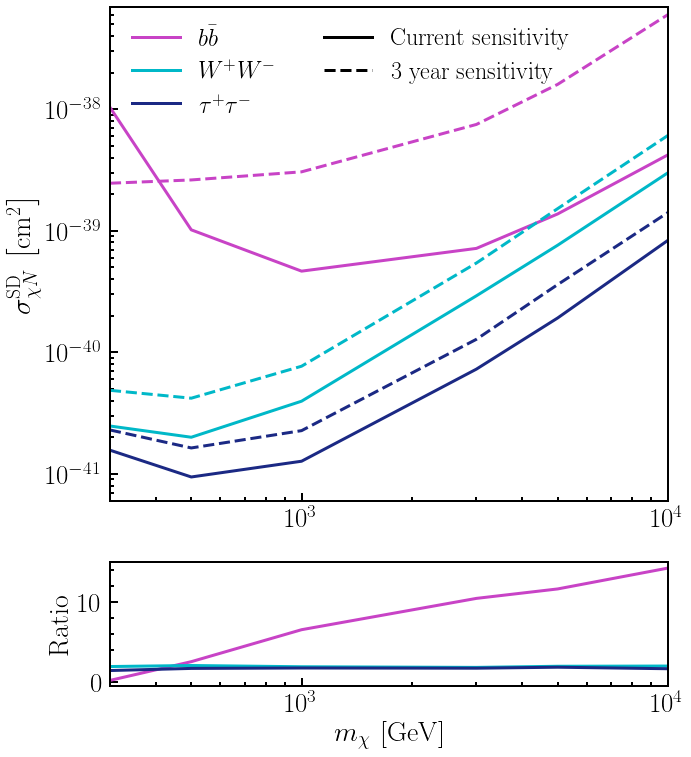

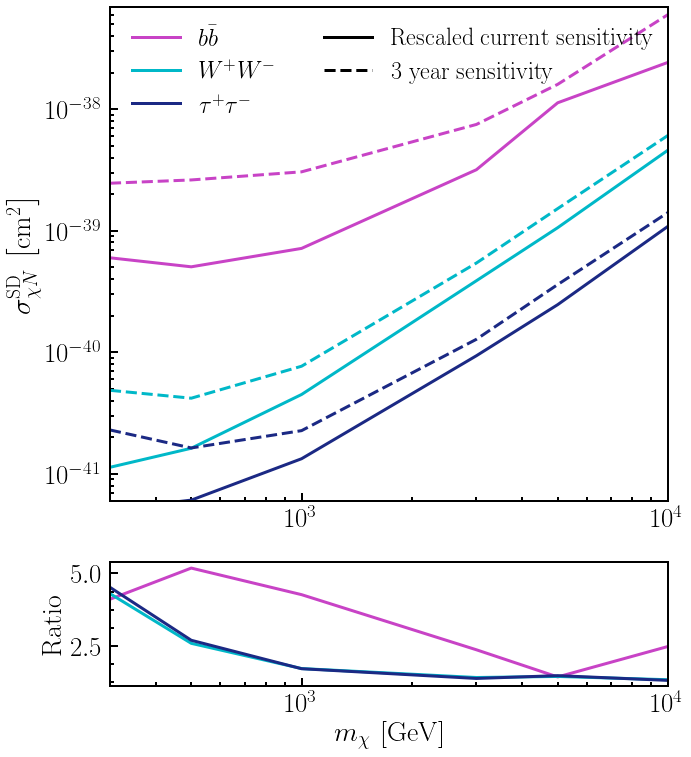

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


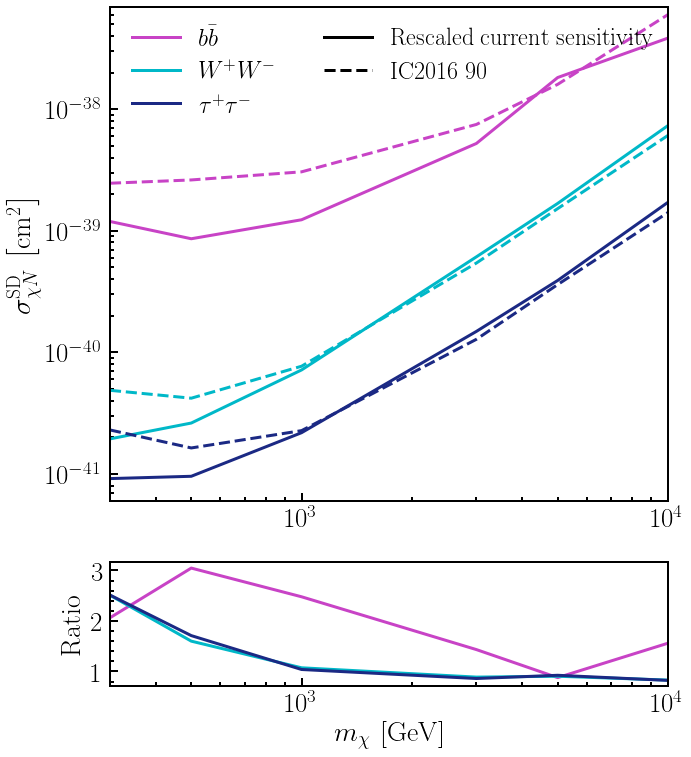

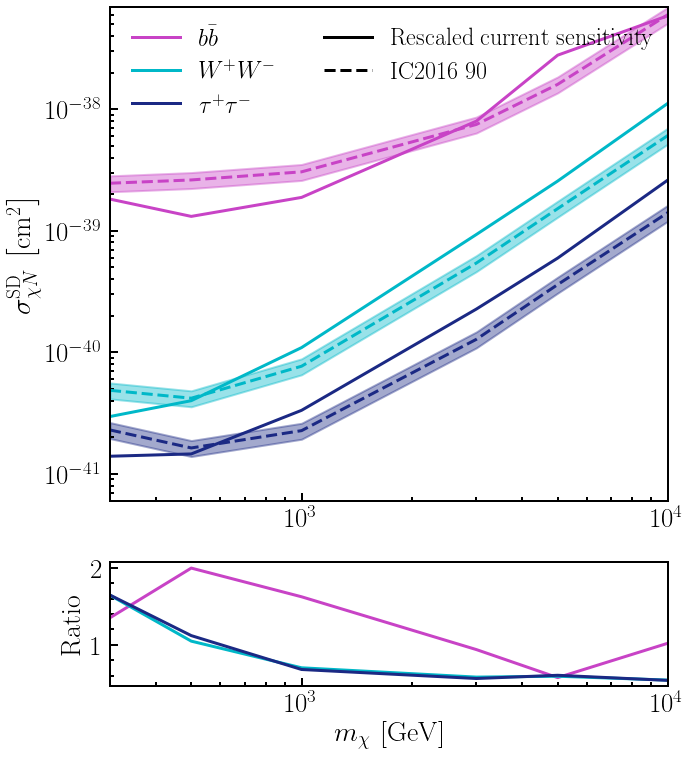

In [41]:
plt.style.use("../paper.mplstyle")

chs = [5,8,11]
ms  = [300, 500, 1000, 3000, 5000, 10000]
cs  = ["#C843C6", "#00B8C8", "#1B2984"]
lw  = 3
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
delta_t = 30*60

ylims = (6e-42, 7e-38)
xlims=(300,10000)
# old_lims_scaled = [[sd_limits[ch][m]*1e-36/factors[ch][m] for m in ms] for ch in chs]
# old_lims = [[sd_limits[ch][m]*1e-36 for m in ms] for ch in chs]
old_sens = [[np.power(10, sens_funcs[ch](np.log10(m))) for m in ms] for ch in chs]

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax0, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

legend_elements = [Line2D([0], [0], color=cs[0], linestyle="-", label=r"$b\bar{b}$", lw=lw),
                   Line2D([0], [0], color=cs[1], linestyle="-", label=r"$W^{+}W^{-}$", lw=lw),
                   Line2D([0], [0], color=cs[2], linestyle="-", label=r"$\tau^{+}\tau^{-}$", lw=lw),
                   Line2D([0], [0], color="black", linestyle="-", label=r"Current sensitivity", lw=lw),
                   Line2D([0], [0], color="black", linestyle="--", label=r"3 year sensitivity", lw=lw),
                  ]


for i, (c, ch, chstr) in enumerate(zip(cs,chs, ch_strs)):
    lims = []
    rs_lims = []
    for m in ms:

        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

        if m in [500,1000,5000,10000]:
            signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
        else:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
            
        bg  = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t
        
        lims.append(calc_sens(bg, signal))
#     ax0.plot(ms, np.asarray(lims), color=c, lw=lw, label=chstr)
    ax0.plot(ms, np.asarray(lims), color=c, lw=lw)
    ax0.plot(ms, old_sens[i], color=c, lw=lw, ls='--')
#     ax1.plot(ms, np.divide(old_lims[i], lims), color=c, lw=lw)
    ax1.plot(ms, np.divide(old_sens[i], lims), color=c, lw=lw)
ax0.loglog()
ax0.legend(handles=legend_elements, ncol=2, loc='upper left', frameon=False, fontsize=24)
ax0.set_xlim(xlims)
ax0.set_ylim(ylims)
ax0.set_ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')

ax1.semilogx()
ax1.set_xlim(xlims)
ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
ax1.set_ylabel(r'Ratio')

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)
    ax1.spines[axis].set_linewidth(2)
    
###############

# plt.savefig('../plots/nominal_sensitivity.pdf', bbox_inches='tight')
plt.show()
fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax0, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

legend_elements = [Line2D([0], [0], color=cs[0], linestyle="-", label=r"$b\bar{b}$", lw=lw),
                   Line2D([0], [0], color=cs[1], linestyle="-", label=r"$W^{+}W^{-}$", lw=lw),
                   Line2D([0], [0], color=cs[2], linestyle="-", label=r"$\tau^{+}\tau^{-}$", lw=lw),
                   Line2D([0], [0], color="black", linestyle="-", label=r"Rescaled current sensitivity", lw=lw),
                   Line2D([0], [0], color="black", linestyle="--", label=r"3 year sensitivity", lw=lw),
                  ]

for i, (c, ch, chstr) in enumerate(zip(cs,chs, ch_strs)):
    lims = []
    rs_lims = []
    for m in ms:

        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

        if m in [500,1000,5000,10000]:
            signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
        else:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
        
        bg        = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t
        lims.append(calc_sens(bg, signal)*factors[ch][m])

    ax0.plot(ms, np.asarray(lims), color=c, lw=lw)
    ax0.plot(ms, old_sens[i], color=c, lw=lw, ls='--')
#     ax0.plot(ms, old_lims[i], color=c, lw=lw, ls='--')
    ax1.plot(ms, np.divide(old_sens[i], lims), color=c, lw=lw, label=chstr )
#     ax1.plot(ms, np.divide(old_lims_scaled[i], lims), color=c, lw=lw, label=chstr )

ax0.loglog()
ax0.legend(handles=legend_elements, ncol=2, loc='upper left', frameon=False, fontsize=24)
ax0.set_xlim(xlims)
ax0.set_ylim(ylims)
ax0.set_ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')

ax1.semilogx()
ax1.set_xlim(xlims)
ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
ax1.set_ylabel(r'Ratio')

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)
    ax1.spines[axis].set_linewidth(2)

# plt.savefig('../plots/rescale_sensitivity_0.pdf', bbox_inches='tight')

plt.show()

####

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax0, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

legend_elements = [Line2D([0], [0], color=cs[0], linestyle="-", label=r"$b\bar{b}$", lw=lw),
                   Line2D([0], [0], color=cs[1], linestyle="-", label=r"$W^{+}W^{-}$", lw=lw),
                   Line2D([0], [0], color=cs[2], linestyle="-", label=r"$\tau^{+}\tau^{-}$", lw=lw),
                   Line2D([0], [0], color="black", linestyle="-", label=r"Rescaled current sensitivity", lw=lw),
                   Line2D([0], [0], color="black", linestyle="--", label=r"IC2016 90% C.L.", lw=lw),
                  ]

for i, (c, ch, chstr) in enumerate(zip(cs,chs, ch_strs)):
    lims = []
    rs_lims = []
    for m in ms:
        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

        if m in [500,1000,5000,10000]:
            if m in [500,1000,5000,10000]:
                signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
#             if m not in [300, 500, 1000]:
#                 signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
            else:
                signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
        else:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
        
        bg        = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t
        lims.append(calc_sens(bg, signal)*factors[ch][m])
        
    ax0.plot(ms, np.asarray(lims), color=c, lw=lw)
    ax0.plot(ms, old_sens[i], color=c, lw=lw, ls='--')
    ax1.plot(ms, np.divide(old_sens[i], lims), color=c, lw=lw, label=chstr )
#     ax1.plot(ms, np.divide(old_lims_scaled[i], lims), color=c, lw=lw, label=chstr )

ax0.loglog()
ax0.legend(handles=legend_elements, ncol=2, loc='upper left', frameon=False, fontsize=24)
ax0.set_xlim(xlims)
ax0.set_ylim(ylims)
ax0.set_ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')

ax1.semilogx()
ax1.set_xlim(xlims)
ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
ax1.set_ylabel(r'Ratio')

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)
    ax1.spines[axis].set_linewidth(2)

# plt.savefig('../plots/rescale_sensitivity_1.pdf', bbox_inches='tight')

plt.show()

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax0, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, (c, ch, chstr) in enumerate(zip(cs,chs, ch_strs)):
    lims = []
    rs_lims = []
    for m in ms:

        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

        if m in [500,1000,5000,10000]:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
#             if m not in [300, 500, 1000]:
#                 signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
#             else:
#                 signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
        else:
            signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m))
        
        bg        = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t


        lims.append(calc_sens(bg, signal)*factors[ch][m]) 
    ax0.plot(ms, np.asarray(lims/np.sqrt(3./7)), color=c, lw=lw, label=chstr)
    ax0.plot(ms, np.asarray(old_sens[i]), color=c, lw=lw, ls='--')
#     ax0.plot(ms, np.asarray(old_lims_scaled[i])*np.sqrt(3./7), color=c, lw=lw, ls='--')
    ax0.fill_between(ms, 1.15*np.asarray(old_sens[i]), 0.85*np.asarray(old_sens[i]), color=c, alpha=0.4)
    ax1.plot(ms, np.divide(np.asarray(old_sens[i]), np.asarray(lims)/np.sqrt(3./7)), color=c, lw=lw, label=chstr )

ax0.loglog()
ax0.legend(handles=legend_elements, ncol=2, loc='upper left', frameon=False, fontsize=24)
ax0.set_xlim(xlims)
ax0.set_ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')
ax0.set_ylim(ylims)

ax1.semilogx()
ax1.set_xlim(xlims)
ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
ax1.set_ylabel(r'Ratio')

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)
    ax1.spines[axis].set_linewidth(2)
    
# plt.savefig('../plots/rescale_sensitivity_2.pdf', bbox_inches='tight')

plt.show()

In [77]:
chs = [5,8,11]
# ms  = [300, 500, 800, 1000, 3000, 5000, 8000, 10000]
ms  = [300, 500, 1000, 3000, 5000, 10000]
cs  = ["#C843C6", "#00B8C8", "#1B2984"]
lw  = 3
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
ylims = (6e-42, 7e-38)
xlims=(300,10000)
delta_t = 30*60

legend_elements = [Line2D([0], [0], color=cs[0], linestyle="-", label=r"$b\bar{b}$", lw=lw),
                   Line2D([0], [0], color=cs[1], linestyle="-", label=r"$W^{+}W^{-}$", lw=lw),
                   Line2D([0], [0], color=cs[2], linestyle="-", label=r"$\tau^{+}\tau^{-}$", lw=lw),
                   Line2D([0], [0], color="black", linestyle="-", label=r"Rescaled current sensitivity", lw=lw),
                   Line2D([0], [0], color="black", linestyle="--", label=r"IC2016 90% C.L.", lw=lw),
                  ]

def make_sens_plot(syst_type):
    print(syst_type)
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax0, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))
    
    for (c, ch, chstr) in zip(cs,chs, ch_strs):
        lims = np.zeros(len(ms))
        nom_lims = np.zeros(len(ms))
        for j, m in enumerate(ms):
            
            factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

            if m in [500,1000,5000,10000]:
                signal = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
            else:
                signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m))
            print(ch,m)
            print(np.sum(signal))
            bg  = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t
            print('tot nominal bg==%f' % np.sum(bg))
            nom_lims[j] = calc_sens(bg, signal)

                
            if syst_type!='Nominal':
                if m in [500,1000,5000,10000]:
                    signal  = 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_%s_e_d_theta.npy' % (ch, m, syst_type))
                    signal += 2*factor * np.load('../data/e_d_theta_hist/ch%d-m%d_LE_%s_e_d_theta.npy' % (ch, m, syst_type))
                    print(ch,m)
                    print(np.sum(signal))
                    
                else:
                    signal = factor * np.load('../data/e_d_theta_hist/ch%d-m%d_%s_e_d_theta.npy' % (ch, m, syst_type))
                    signal += factor * np.load('../data/e_d_theta_hist/ch%d-m%d_LE_%s_e_d_theta.npy' % (ch, m, syst_type))
                    print(ch,m)
                    print(np.sum(signal))
                bg = np.load('../data/e_d_theta_hist/conv-numu_%s_e_d_theta.npy' % syst_type)*delta_t
                print('tot syst. bg==%f' % np.sum(bg))

                lims[j] = calc_sens(bg, signal)
                    

            
        if syst_type!='Nominal':
            ax0.plot(ms, np.asarray(lims), color=c, ls='-.', lw=lw)
            ax0.plot(ms, np.asarray(nom_lims), color=c, lw=lw, label=chstr)
            ax1.plot(ms, np.divide(nom_lims-lims, nom_lims), c=c)



    ax0.set_ylabel(r'$\sigma_{\chi N}^{\rm{SD}}\,\left[\rm{cm}^{2}\right]$')
    ax1.set_xlabel(r'$m_{\chi}\,\left[\rm{GeV}\right]$')
    ax1.set_ylabel(r'(Nom.-Syst.)/Nom.')
    ax0.set_title(syst_type)
    ax0.loglog()
    ax1.semilogx()
    ax0.legend()
    ax0.set_xlim(300,10000)
    ax1.set_xlim(300,10000)
    ax0.set_ylim(ylims)
    ax1.set_ylim(-0.1, 0.1)
    plt.show()

BulkIce1
(5, 300)
2.537089668189689
tot nominal bg==318395.263456


/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


(5, 300)
0.44761852037868544
tot syst. bg==322594.206861


/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
15.619198186822103
tot syst. bg==322594.206861
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
49.395791354170875
tot syst. bg==322594.206861
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
34.52531348642147
tot syst. bg==322594.206861
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
18.023262968307776
tot syst. bg==322594.206861
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
5.8562681391781615
tot syst. bg==322594.206861
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
912.2579408710191
tot syst. bg==322594.206861
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
1250.3265302135035
tot syst. bg==322594.206861
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
628.0870368880468
tot syst. bg==322594.206861
(8, 3000)
83.40576896096432
tot nominal bg==318395.263456
(8, 3000)
84.46777144645297
to

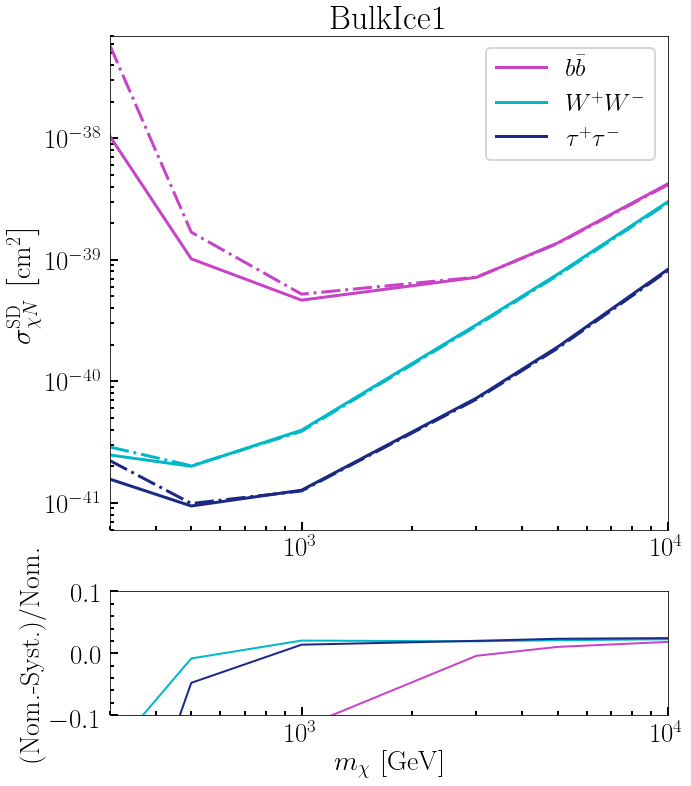

BulkIce5
(5, 300)
2.537089668189689
tot nominal bg==318395.263456
(5, 300)
0.37576456945078973
tot syst. bg==121943.527018
(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
6.981612139003818
tot syst. bg==121943.527018
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
19.415681497786103
tot syst. bg==121943.527018
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
13.221199067728703
tot syst. bg==121943.527018
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
6.883148737844614
tot syst. bg==121943.527018
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
2.2352072110823817
tot syst. bg==121943.527018
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
363.4811808696117
tot syst. bg==121943.527018
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
478.69987791411086
tot syst. bg==121943.527018
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
239.11129459

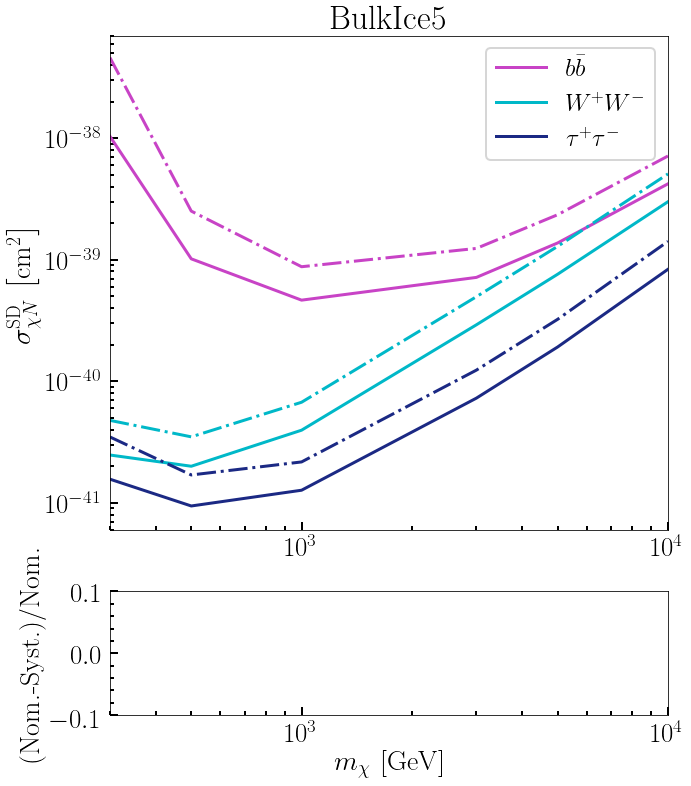

HoleIce1
(5, 300)
2.537089668189689
tot nominal bg==318395.263456
(5, 300)
0.44195444161596636
tot syst. bg==327045.318944
(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
15.782154825842241
tot syst. bg==327045.318944
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
50.09645219827494
tot syst. bg==327045.318944
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
35.09647572049322
tot syst. bg==327045.318944
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
18.32277062700457
tot syst. bg==327045.318944
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
5.935239482522232
tot syst. bg==327045.318944
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
931.9561714386487
tot syst. bg==327045.318944
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
1261.1971937414312
tot syst. bg==327045.318944
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
635.9158630530

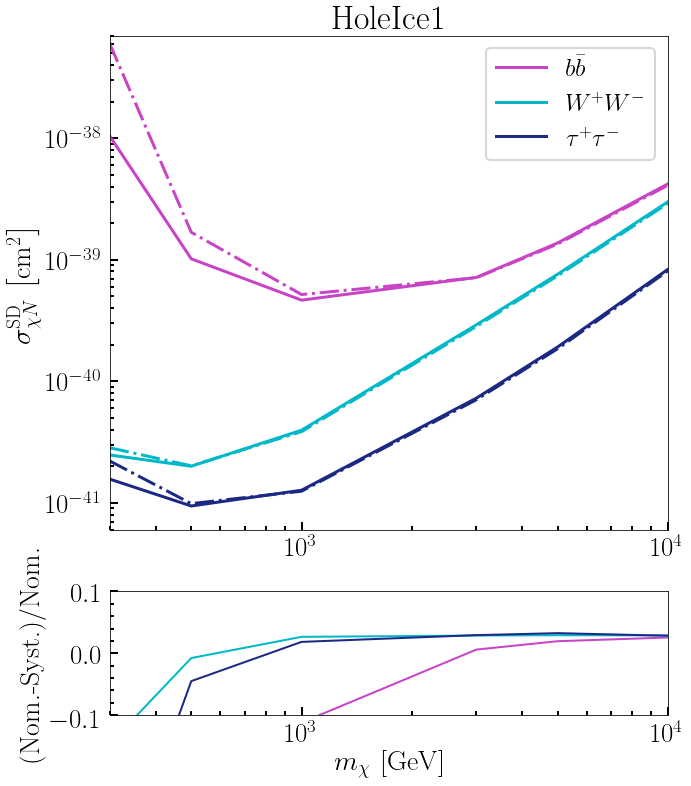

HoleIce3
(5, 300)
2.537089668189689
tot nominal bg==318395.263456
(5, 300)
0.45366942803144134
tot syst. bg==326721.022691
(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
16.06726764528664
tot syst. bg==326721.022691
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
50.82099632925341
tot syst. bg==326721.022691
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
35.551378220146596
tot syst. bg==326721.022691
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
18.5408261327795
tot syst. bg==326721.022691
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
6.0085393952371495
tot syst. bg==326721.022691
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
948.0821019360983
tot syst. bg==326721.022691
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
1283.753172727636
tot syst. bg==326721.022691
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
643.59244439094

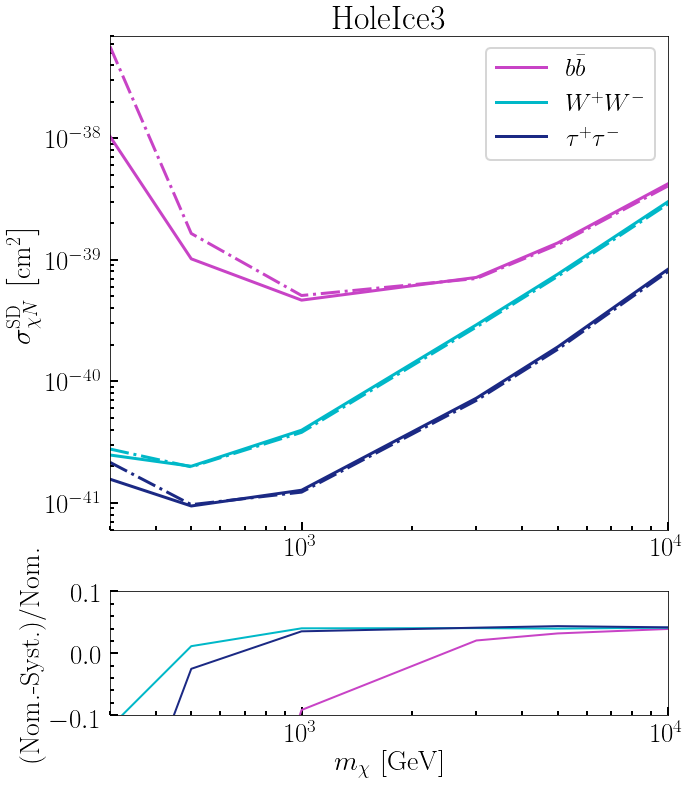

HoleIce4
(5, 300)
2.537089668189689
tot nominal bg==318395.263456
(5, 300)
0.443600884114869
tot syst. bg==315317.274412
(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
15.455098788382038
tot syst. bg==315317.274412
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
48.854999029211136
tot syst. bg==315317.274412
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
33.98003516041115
tot syst. bg==315317.274412
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
17.72058970649449
tot syst. bg==315317.274412
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
5.763240516309213
tot syst. bg==315317.274412
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
902.4434872560889
tot syst. bg==315317.274412
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
1234.7568290784427
tot syst. bg==315317.274412
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
615.11796511188

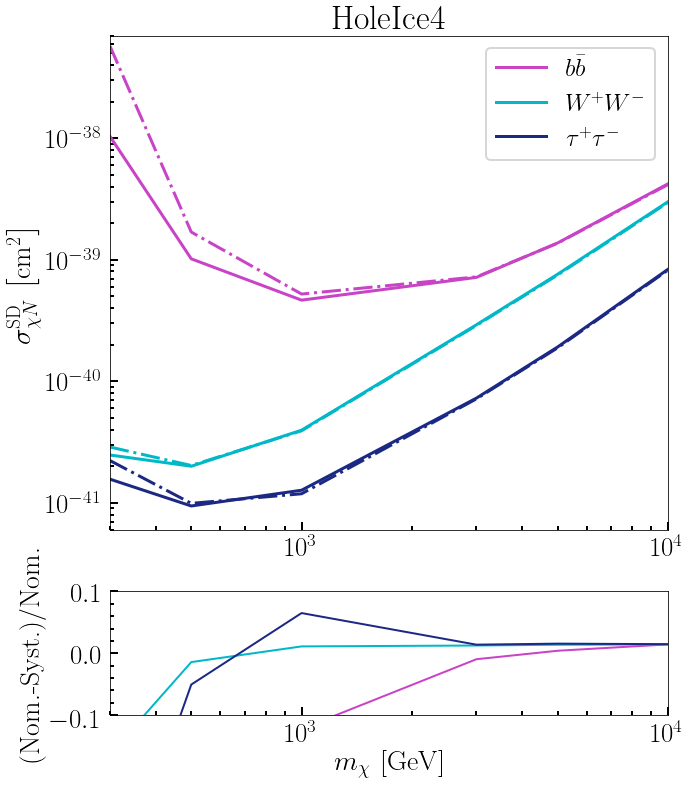

HoleIce5
(5, 300)
2.537089668189689
tot nominal bg==318395.263456
(5, 300)
0.45310615367598556
tot syst. bg==316923.659630
(5, 500)
26.355508187817318
tot nominal bg==318395.263456
(5, 500)
15.503009330633136
tot syst. bg==316923.659630
(5, 1000)
56.43834752444687
tot nominal bg==318395.263456
(5, 1000)
49.30158023345404
tot syst. bg==316923.659630
(5, 3000)
35.09647671229874
tot nominal bg==318395.263456
(5, 3000)
34.29486505283798
tot syst. bg==316923.659630
(5, 5000)
17.99496009122407
tot nominal bg==318395.263456
(5, 5000)
17.94591869591608
tot syst. bg==316923.659630
(5, 10000)
5.780182204396506
tot nominal bg==318395.263456
(5, 10000)
5.824509021350613
tot syst. bg==316923.659630
(8, 300)
1080.890080667661
tot nominal bg==318395.263456
(8, 300)
915.2167945232957
tot syst. bg==316923.659630
(8, 500)
1274.88785077637
tot nominal bg==318395.263456
(8, 500)
1242.5487414644551
tot syst. bg==316923.659630
(8, 1000)
618.897296150769
tot nominal bg==318395.263456
(8, 1000)
623.3809031819

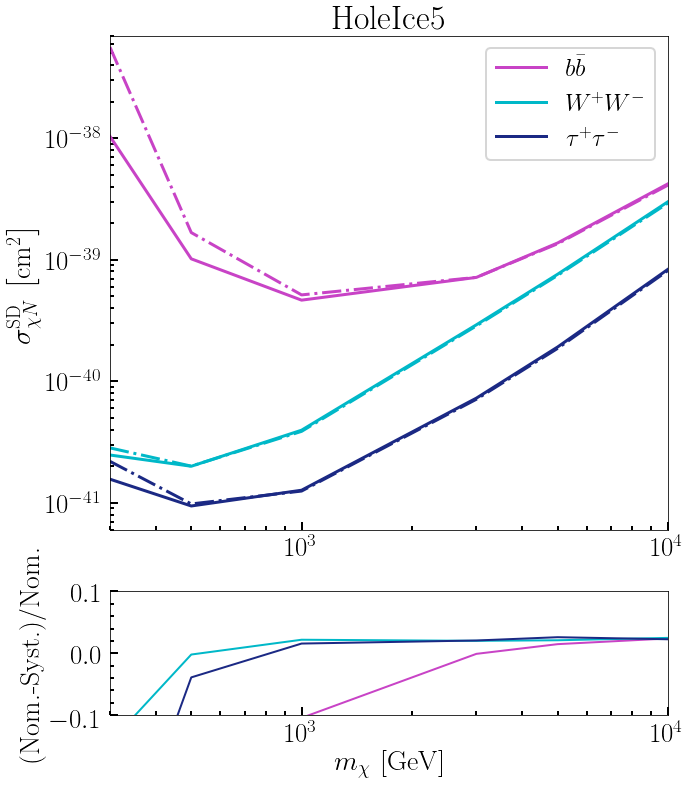

In [78]:
# make_sens_plot('Noise')

make_sens_plot('BulkIce1')
# make_sens_plot('BulkIce2')
make_sens_plot('BulkIce5')

make_sens_plot('HoleIce1')
make_sens_plot('HoleIce3')
make_sens_plot('HoleIce4')
make_sens_plot('HoleIce5')



In [65]:
delta_t=30*60
tot_bg = np.sum(np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy'))*delta_t
print('total bg events expected in 7 years: %f' % tot_bg)
plt.imshow(np.log10(np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy').T[::-1][-36:-10,:41]),
           aspect='auto',
           extent=[0,20,1.5,4]
          )
plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{bg}}\right)$')

plt.show()
plt.imshow(np.log10((1. / 1000) * sd_anns[1000] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch5-m1000_Nominal_e_d_theta.npy').T[::-1][-36:-10,:41]),
           aspect='auto',
           extent=[0,20,1.5,4]
          )

plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{sig}}\right)$')

plt.show()

total bg events expected in 7 years: 318395.263456


KeyboardInterrupt: 

In [26]:
def neg_log_likelihood(mu_s, n_s, mu_b, n_b):
    """
    mu_s float: mean number of signal events
    n_s  int  : observed number of signal events
    mu_b float: mean number of background events
    n_b  int  : observed number of bacground events
    """
    mu_s = np.asarray(mu_s)
    mu_b = np.asarray(mu_b)
    n_b  = np.asarray(n_b)
    n_s  = np.asarray(n_s)
    mu = mu_s*n_s + mu_b*n_b
    lh = -np.log(np.exp(-mu) * np.power(mu, mu_b) / factorial(mu_b))
    lh = lh[np.where(~np.isnan(lh))]
    lh = lh[np.where(~np.isinf(lh))]
    return np.sum(lh)
def calc_sens(mu_b, mu_s, yint=2.71, makeplot=False):
    
    n_b  = 1
    
    neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_b, n_b)

    func = lambda x: neg_log_likelihood(mu_s, x, mu_b, n_b) - neg_log_likelihood_0 - yint
    if makeplot:
        xx = np.linspace(0,5,100)
        plt.plot(xx, [func(x) for x in xx])
        plt.show()
    sens = broyden1(func, 0.5)
    return sens

In [ ]:
mus = np.load('../data/e_d_theta_hist/solar-atm_Nominal_e_d_theta.npy')*delta_t*8/7
mub = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t*8/7
calc_sens(mub, mus, makeplot=True)

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Total number of events in 8 yrs=1.918314


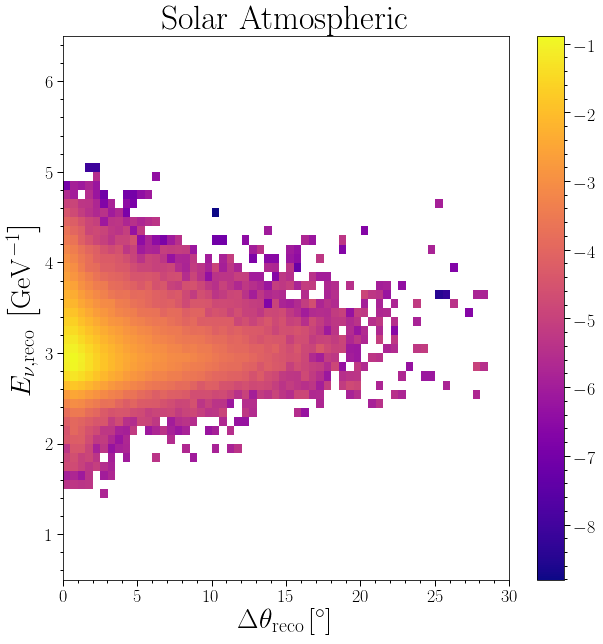

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


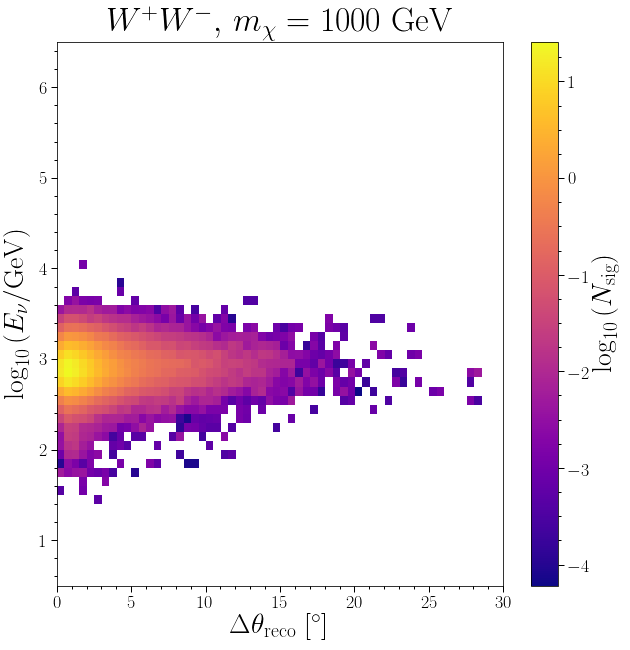

total bg events expected in 8 years: 363880.301092


/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


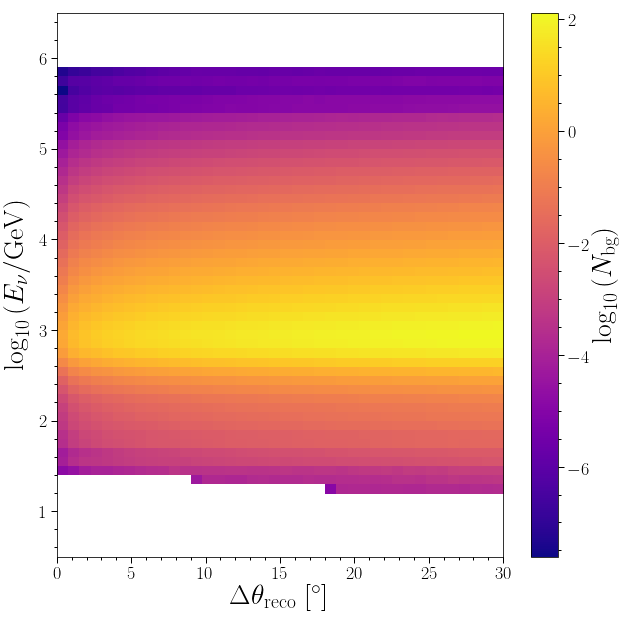

In [6]:
delta_t=30*60.
plt.imshow(np.log10(np.load('../data/e_d_theta_hist/solar-atm_Nominal_e_d_theta.npy')[:60]*30*60*8/7).T[::-1], 
           aspect='auto',
           extent=[0,30,0.5,6.5]
          )
print('Total number of events in 8 yrs=%f' % np.sum(np.load('../data/e_d_theta_hist/solar-atm_Nominal_e_d_theta.npy')*30*60*8/7))
plt.title('Solar Atmospheric')
plt.xlabel(r'$\Delta\theta_{\rm{reco}}\,[^\circ]$')
plt.ylabel(r'$E_{\nu,\rm{reco}}\,\left[\rm{GeV}^{-1}\right]$')
plt.colorbar()
plt.show()

plt.imshow(np.log10(8/7 * (1. / 1000) * sd_anns[1000] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta.npy').T[::-1][:,:60]),
           aspect='auto',
           extent=[0,30,0.5,6.5]
          )
plt.title(r'$W^{+}W^{-},\, m_{\chi}=1000~\rm{GeV}$')
plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{sig}}\right)$')

plt.show()

tot_bg = np.load('../data/e_d_theta_hist/conv-numu_Nominal_e_d_theta.npy')*delta_t*8/7
print('total bg events expected in 8 years: %f' % np.sum(tot_bg))
plt.imshow(np.log10(tot_bg.T[::-1][:,:40]),
           aspect='auto',
           extent=[0,30,0.5,6.5]
          )
plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{bg}}\right)$')

plt.show()

In [53]:
np.sum(np.load('../data/e_d_theta_hist/ch5-m10000_Nominal_e_d_theta_rescale.npy'))

9.545131440624212e-19

In [54]:
np.sum(np.load('../data/e_d_theta_hist/ch5-m10000_Nominal_e_d_theta_rescale.npy'))

9.545131440624212e-19

In [55]:
get_limit(1000, 11)

2.8538519789627073e-41

In [73]:
dicts.si_ann_rate_dict[1000]*2.0e-06/3.56e21

0.7560292456028448

In [ ]:
print('butt')

In [14]:
3.18e5/7./3.14/10**7.5*1000./2

0.2287543894298327

In [45]:
print(2*np.sum(np.load('../data/e_d_theta_hist/ch5-m1000_Nominal_e_d_theta.npy')))
print(np.sum(np.load('../data/e_d_theta_hist/ch5-m1000_Nominal_e_d_theta_rescale.npy')))

1.8667836592529518e-20
1.855833512964377e-20


In [52]:
for ch in [5,8,11]:
    for m in [500, 1000, 5000, 10000]:
        print(ch, m)
        we = 2*np.sum(np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta.npy' % (ch, m)))
        we_r = np.sum(np.load('../data/e_d_theta_hist/ch%d-m%d_Nominal_e_d_theta_rescale.npy' % (ch, m)))
        print(we)
        print(we_r)
        print(np.abs(we-we_r)/we)

(5, 500)
1.0931585186178038e-21
1.054068493325111e-21
0.03575878944082006
(5, 1000)
1.8667836592529518e-20
1.855833512964377e-20
0.005865782161901334
(5, 5000)
7.432538606602747e-19
7.203967116134503e-19
0.030752815769458847
(5, 10000)
1.9099845311574317e-18
1.9177121441578902e-18
0.004045903448116267
(8, 500)
5.2879060590557726e-20
4.988219829752525e-20
0.05667389434614134
(8, 1000)
2.04709636246816e-19
2.0057076697241192e-19
0.020218243509621082
(8, 5000)
1.3155851640142629e-18
1.2709376819906215e-18
0.03393735597276565
(8, 10000)
2.673288465843238e-18
2.576745934101741e-18
0.03611377259694439
(11, 500)
1.140500549436969e-19
1.1473909532209165e-19
0.0060415611262521225
(11, 1000)
6.482910231175641e-19
6.265977107017254e-19
0.03346230572732265
(11, 5000)
5.200160052998791e-18
5.1035637465030096e-18
0.018575641040140048
(11, 10000)
9.582607912521884e-18
9.252186632176737e-18
0.03448135240025579


/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


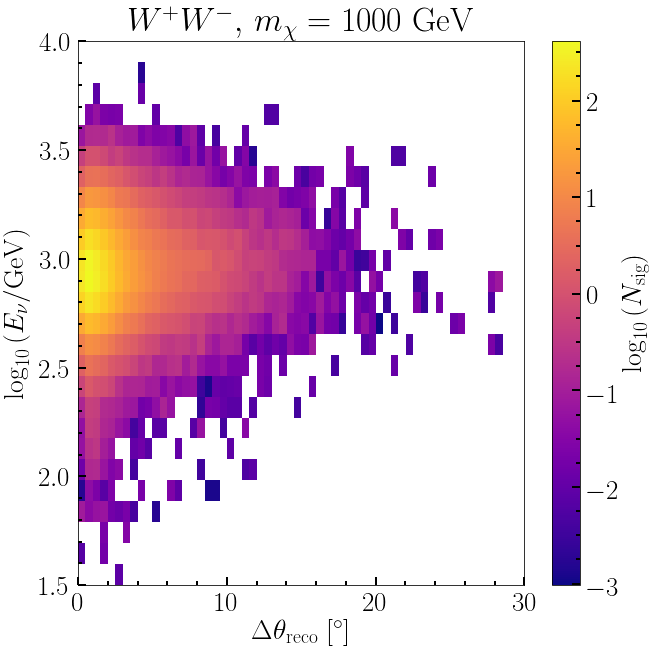

409.63993268914976


In [71]:
plt.imshow(np.log10((2*1./ 500)*sd_anns[500]*1e-3*delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta.npy').T[::-1][25:51,:60]),
           aspect='auto',
           extent=[0,30,1.5,4]
          )
plt.title(r'$W^{+}W^{-},\, m_{\chi}=1000~\rm{GeV}$')
plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{sig}}\right)$')

plt.show()
print(np.max((2 * 1. / 500) * sd_anns[500] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta.npy').T[::-1][:,:60]))

In [70]:
np.log10(np.logspace(0.5,6.5, 61)[::-1][25:51])

array([4. , 3.9, 3.8, 3.7, 3.6, 3.5, 3.4, 3.3, 3.2, 3.1, 3. , 2.9, 2.8,
       2.7, 2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2. , 1.9, 1.8, 1.7, 1.6, 1.5])

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


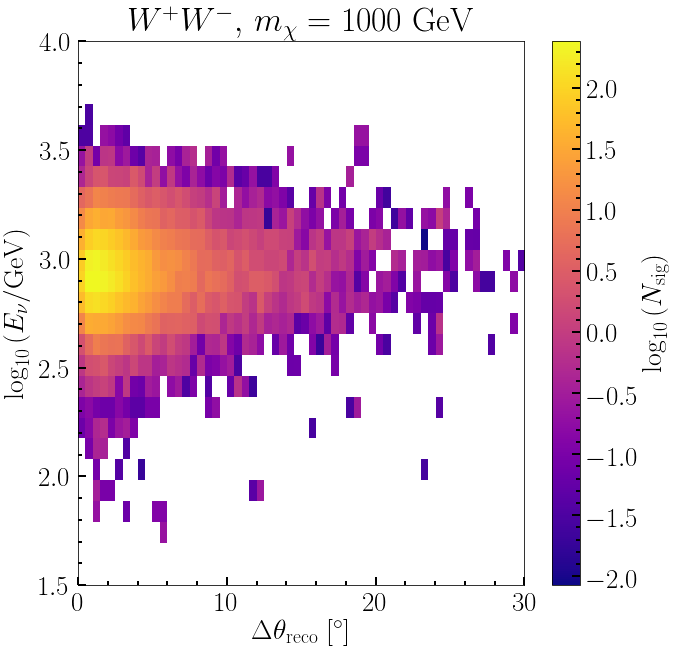

241.68289444770303


In [72]:
plt.imshow(np.log10((1. / 500) * sd_anns[500] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta_rescale.npy').T[::-1][25:51,:60]),
           aspect='auto',
           extent=[0,30,1.5,4]
          )
plt.title(r'$W^{+}W^{-},\, m_{\chi}=1000~\rm{GeV}$')
plt.xlabel(r'$\Delta\theta_{\rm{reco}}~[^{\circ}]$')
plt.ylabel(r'$\log_{10}\left(E_{\nu}/\rm{GeV}\right)$')
cbar=plt.colorbar(label=r'$\log_{10}\left(N_{\rm{sig}}\right)$')

plt.show()

print(np.max((1. / 500) * sd_anns[500] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta_rescale.npy').T[::-1][:,:60]))

In [57]:
print(np.sum((1. / 500) * sd_anns[500] * 1e-3 * delta_t*np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta_rescale.npy').T[::-1][:,:60]))

4970.754789716148


In [5]:
from scipy.interpolate import splev, splrep
from scipy.integrate import quad

In [6]:
blah[min(np.argwhere(np.isinf(we)))]

NameError: name 'blah' is not defined

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


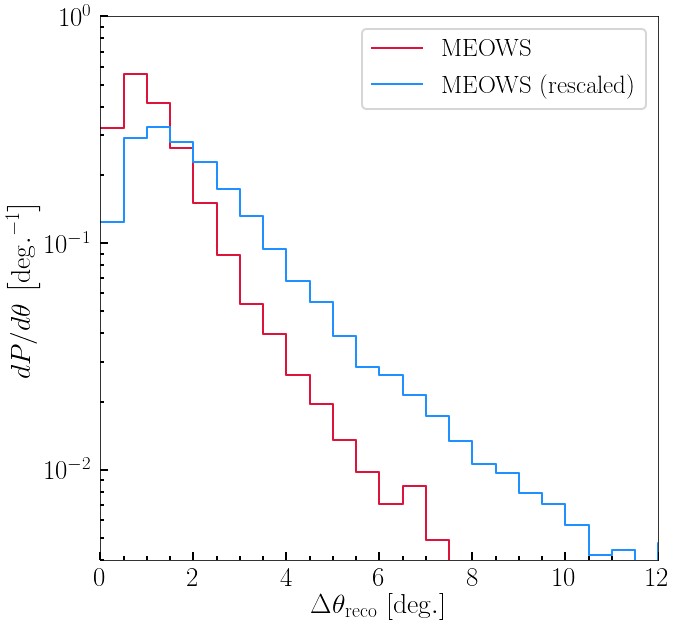

In [7]:
blah = np.linspace(0, 179.5, 360)
we   = np.log(np.sum(np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta.npy'), axis=1))
we_r = np.log(np.sum(np.load('../data/e_d_theta_hist/ch8-m1000_Nominal_e_d_theta_rescale.npy'), axis=1))

we_isfinite = np.where(np.isfinite(we))[0]
wer_isfinite = np.where(np.isfinite(we_r))[0]

we_tck = splrep(blah[we_isfinite], we[we_isfinite])
wer_tck = splrep(blah[wer_isfinite], we_r[wer_isfinite])

we_lims  = (0, blah[min(np.argwhere(np.isinf(we)))])
wer_lims = (0, blah[min(np.argwhere(np.isinf(we_r)))])

plt.step(blah, np.exp(we)/np.sum(np.exp(we))/0.5, where='post', color='crimson', label=r'MEOWS')
plt.step(blah, np.exp(we_r)/np.sum(np.exp(we_r))/0.5, where='post', color='dodgerblue', label=r'MEOWS (rescaled)')
# plt.axvline(0.266, color='crimson')
plt.legend()
plt.semilogy()
plt.xlim(0,12)
plt.ylim(4e-3, 1e0,)
plt.xlim()
plt.xlabel(r'$\Delta\theta_{\rm{reco}}\,\left[\rm{deg.}\right]$')
plt.ylabel(r'$dP/d\theta\,\left[\rm{deg.}^{-1}\right]$')
plt.show()